This notebook is to estimate the solar coronal shock parameters by extracting the frequency and time points from the radio dynamic spectrum

In [1]:
import warnings
warnings.filterwarnings('ignore')

# %matplotlib widget

import numpy as np
np.random.seed(777)
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import astropy.io.fits as fits
import scipy

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

### Import the data file of the radio dynamic spectrum from CALLISTO spectrum, as an example

In [2]:
filename = './DARO_20130502_050001_58.fit.gz'

fds  = fits.open(filename) # access the FIT-file
data = fds[0].data         # read binary table
cols = data[:,:]           # copy data for background analysis
size = cols.shape          # check size of background
columns = size[0]
rows    = size[1]

background = np.mean(cols, axis=1).reshape(columns, 1) # average backgrund array
data2 = data - background                              # subtract background
data2 = data2.clip(-1, 25)                             # adjustment for color-map, just try some numbers

freqs  = fds[1].data['FREQUENCY'][0]                   # read out frequency axis
time   = fds[1].data['TIME'][0]                        # read out time axis
extent = (time[0], time[-1], freqs[-1], freqs[0])      # range for full 2D-image

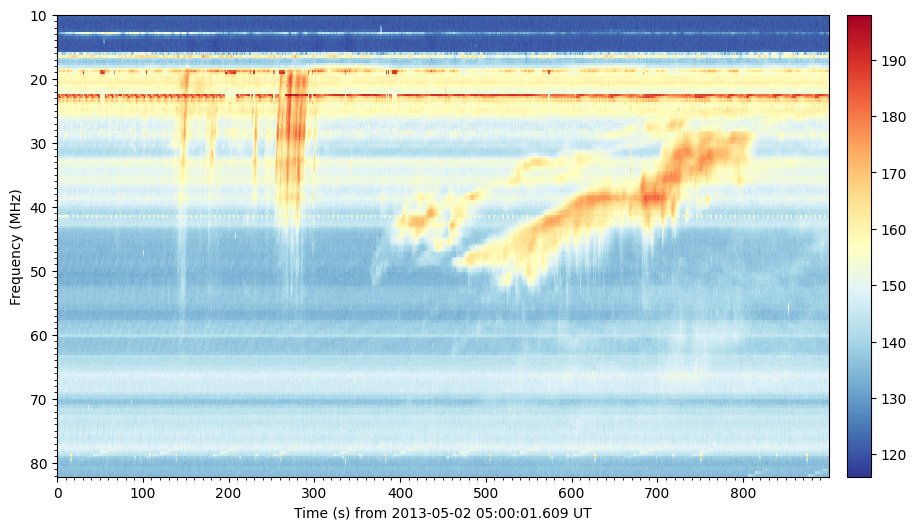

In [3]:
# Plot the raw spectrum
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
img = ax.pcolormesh(time, freqs, data, cmap='RdYlBu_r')
ax.set_xlabel(f"Time (s) from {fds[0].header['DATE']} {fds[0].header['TIME-OBS']} UT")
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_ylim(ax.get_ylim()[::-1])
fig.colorbar(img, pad=0.02)
plt.show()

In [6]:
coords = []
def onclick(event):
    """
    This function is called when the mouse is clicked on the figure.
    It adds the x and y coordinates of the click to the coords list.
    """
    global ix1, iy1
    if event.button == 1:
        ix1, iy1 = event.xdata, event.ydata
        ix2 = ix1 - 8 # offset in frequency, if you want to use the band-splitting
        iy2 = iy1 - 8
        print(f'x = {ix1:.2f}, y = {iy1:.2f}')
        
        ax.plot(ix1, iy1, 'wo', markersize=7)
        ax.plot(ix2, iy2, 'wx', markersize=7)

        global coords
        coords.append((ix1, iy1))
    
    if event.button == 3: # right mouse click terminates interaction
        fig.canvas.mpl_disconnect(cid)
    
    return coords

### Click on the type-II burst to record the (f, t) coorinates

<IPython.core.display.Javascript object>


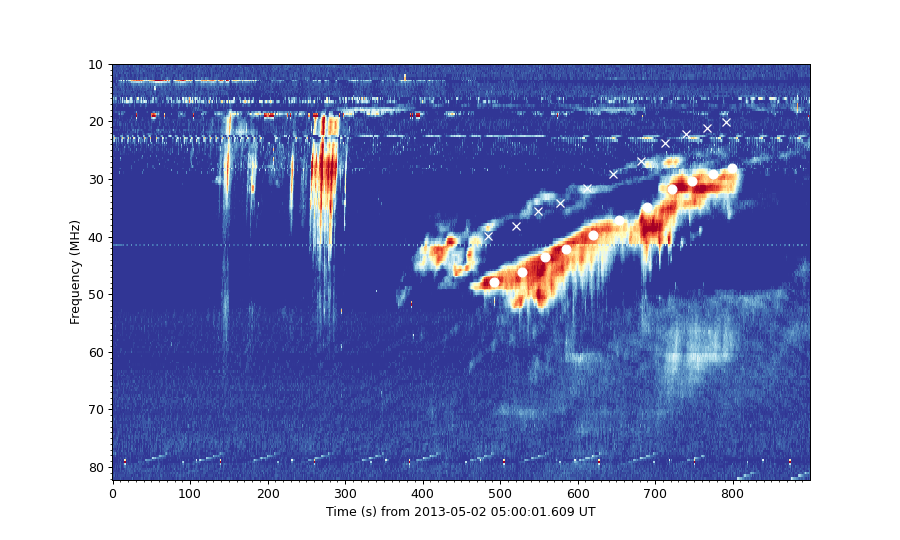

In [7]:
import matplotlib
matplotlib.use('nbAgg')

# Plot the filtered spectrum
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(time, freqs, data2, cmap='RdYlBu_r')
ax.set_xlabel(f"Time (s) from {fds[0].header['DATE']} {fds[0].header['TIME-OBS']} UT")
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_ylim(ax.get_ylim()[::-1])

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

### Export the (f, t) coordinates and estimate the height of the radio source in the corona using the Newkirk electron-density model

In [8]:
with open('typeII_coords.txt', 'w') as fp:        # Save x/y-data in file
    fp.write('Time [s], Frequency [MHz]\n')       # write header information
    for i in range(len(coords)):                  # save all entries
        xn = coords[i][0] 
        yn = coords[i][1]
        st = '{:8.3f}'.format(xn) + ',{:8.3f}'.format(yn)
        fp.write(st + '\n')      

print('Finito, drop file into TEXT now for analysis.')
f = open('typeII_coords.txt', 'r')
ref = np.genfromtxt(f, delimiter=',', skip_header=1)
f.close()

time = ref[:,0]
freq = ref[:,1]

Ne = []
rs = []
vr = []
dfdt = []

# Enter Newkirk model fold number (1, 2, 3 or 4); 1 for quiet Sun, 4 for active regions
alfa = 4
# Enter 1 for fundamental, 2 for harmonic
har = 1

for i in range(0, len(freq)):
    ne = (freq[i] / (har * 8.977e-3))**2 # electron density
    Ne.append(ne)
    rs.append(4.32 / (np.log10(ne/(alfa * 4.2e4)))) # radial distance

Finito, drop file into TEXT now for analysis.


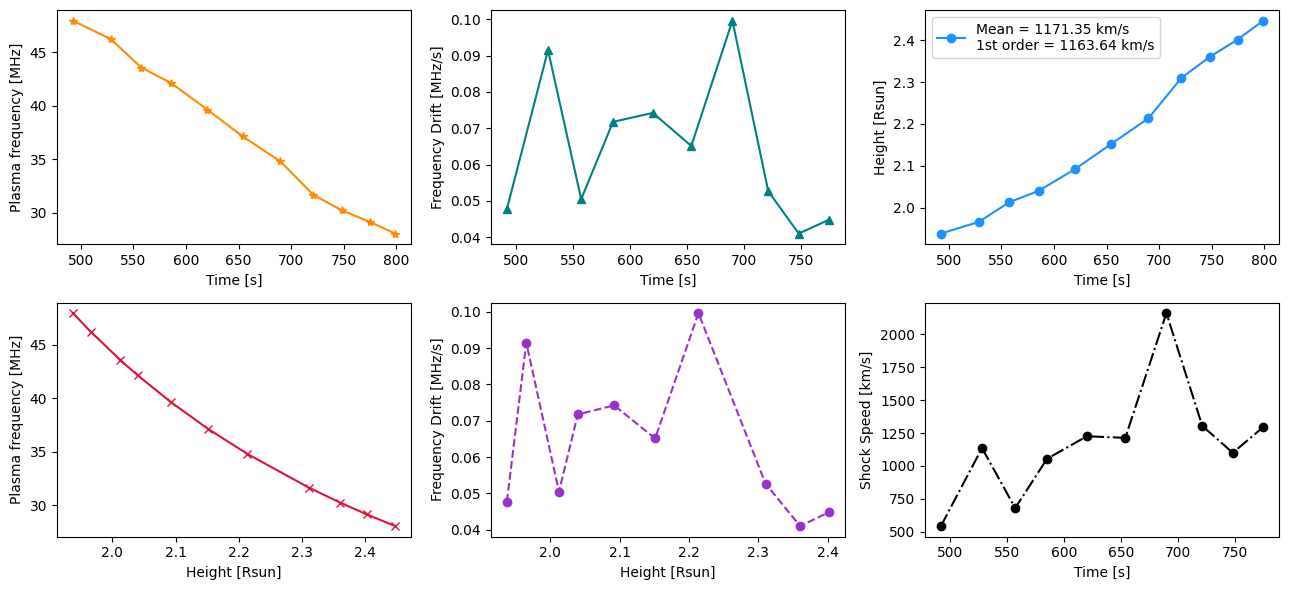

In [10]:
%matplotlib inline

plt.figure(figsize=[13,6])

plt.subplot(2,3,1)
plt.plot(time, freq, '-*', color='darkorange')
# plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Plasma frequency [MHz]')

plt.subplot(2,3,2)
dfdt = np.abs(np.diff(freq)/np.diff(time))
plt.plot(time[:-1], dfdt, '-^', color='teal')
# plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Frequency Drift [MHz/s]')

plt.subplot(2,3,4)
plt.plot(rs, freq, '-x', color='crimson')
# plt.grid()
plt.ylabel('Plasma frequency [MHz]')
plt.xlabel('Height [Rsun]')

plt.subplot(2,3,5)
plt.plot(rs[:-1], dfdt, '--o', color='darkorchid')
# plt.grid()
plt.ylabel('Frequency Drift [MHz/s]')
plt.xlabel('Height [Rsun]')

plt.subplot(2,3,6)
vr = np.diff(rs)/np.diff(time)*700000.0
plt.plot(time[:-1], vr, '-.o', color='black')
# plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Shock Speed [km/s]')

# print('dfdt [MHz/s]: ', dfdt)
# print('Electron density [cm^-3]: ', Ne)
# print('Radius [Rsun]: ', rs)
# for i in range(0, len(freq)-1):
#     print('Benz: ', time[i], 3.5e5*dfdt[i]/freq[i])

ym = np.mean(vr)
v1 = (rs[-1] - rs[0])/(time[-1] - time[0])*700000.0

plt.subplot(2,3,3)
plt.plot(time, rs, '-o', color='dodgerblue', label=f'Mean = {ym:.2f} km/s\n1st order = {v1:.2f} km/s')
# plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Height [Rsun]')
plt.legend()

# print('time: ', time)
# print('rs: ', rs)

plt.tight_layout()
plt.show()

## Use the Bézier curve method

In [11]:
filename = './DARO_20130502_050001_58.fit.gz'

fds  = fits.open(filename) # access the FIT-file
data = fds[0].data         # read binary table
cols = data[:,:]           # copy data for background analysis
size = cols.shape          # check size of background
columns = size[0]
rows    = size[1]

background = np.mean(cols, axis=1).reshape(columns, 1) # average backgrund array
data2 = data - background                              # subtract background
data2 = data2.clip(-1, 25)                             # adjustment for color-map, just try some numbers

freqs  = fds[1].data['FREQUENCY'][0]                   # read out frequency axis
time   = fds[1].data['TIME'][0]                        # read out time axis

In [12]:
def draw_bezier(x1=0, y1=0, x2=0, y2=0, control=[0,0]):
    """
    Draw a Bezier curve using the given control points.
    The curve will be drawn from the point (x1, y1) to the point
    (x2, y2) using the control points (control[0], control[1]).
    """
    A = np.array([x2, y2])
    B = np.array(control)
    C = np.array([x1, y1])

    A = A.reshape(2,1)
    B = B.reshape(2,1)
    C = C.reshape(2,1)
    
    t = np.arange(0, 1, 0.05).reshape(1,-1)
    
    P0 = A * t + (1 - t) * B
    P1 = B * t + (1 - t) * C
    Pfinal = P0 * t + (1 - t) * P1

    return Pfinal

def extract_bezier_values(array, x1, y1, x2, y2, control):
    """
    Extract the values of a Bezier curve at the given control points.
    The curve will be drawn from the point (x1, y1) to the point
    (x2, y2) using the control points (control[0], control[1])
    """
    Pfinal = draw_bezier(x1, y1, x2, y2, control)
    x_coords = np.round(Pfinal[0, :]).astype(int)
    y_coords = np.round(Pfinal[1, :]).astype(int)

    # Clip the coordinates to stay within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)

    # Extract values along the Bézier curve
    bezier_values = array[y_coords, x_coords]
    
    return bezier_values, x_coords, y_coords

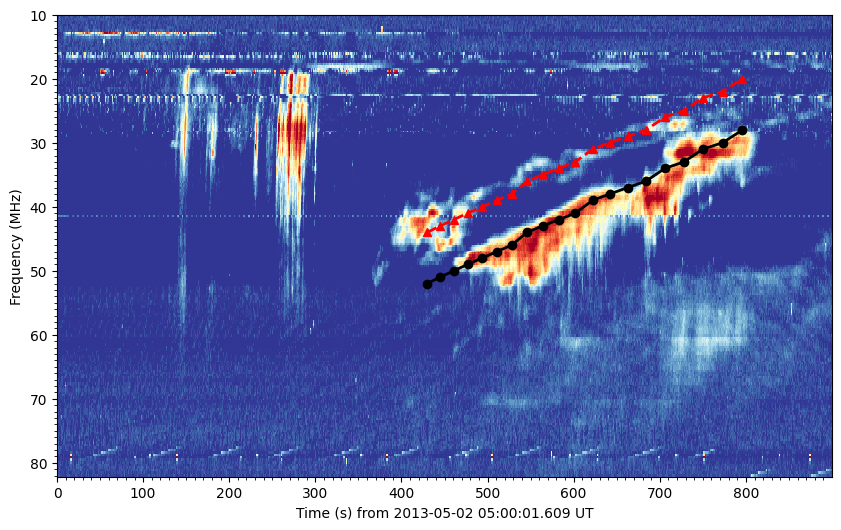

In [13]:
# Plot the spectrum and the Bezier curve
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(time, freqs, data2, cmap='RdYlBu_r')

# Define start and end points and control point for the Bézier curve
x1, y1 = 430, 52
x2, y2 = 820, 27
control = [580, 42]
# Extract values along the Bézier curve
bezier_values_U, x_coords_U, y_coords_U = extract_bezier_values(data2, x1, y1, x2, y2, control)
ax.plot(x_coords_U, y_coords_U, 'ko-', linewidth=2)

# Define start and end points and control point for the Bézier curve
x1, y1 = x1, y1 - 8
x2, y2 = 820, y2 - 8
control = [control[0], control[1]-8]
# Extract values along the Bézier curve
bezier_values_L, x_coords_L, y_coords_L = extract_bezier_values(data2, x1, y1, x2, y2, control)
ax.plot(x_coords_L, y_coords_L, 'r^--', linewidth=2)

ax.set_xlabel(f"Time (s) from {fds[0].header['DATE']} {fds[0].header['TIME-OBS']} UT")
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [16]:
print('Upper frequency band (UFB):')
print(f'intensity values U: {bezier_values_U}\n')
print(f't_coords_U: {x_coords_U}\n')
print(f'f_coords_U: {y_coords_U}')

Upper frequency band (UFB):
intensity values U: [-1.         -1.         -1.         -1.         -1.         -0.77666667
 -0.3375     -1.          0.35333333  0.6225     -0.74777778 -0.62
  0.91527778 -0.01833333 -0.06416667 -0.10916667 -1.         -1.
 -0.66611111 -0.28916667]

t_coords_U: [430 445 461 477 494 511 528 546 564 583 602 622 642 663 684 706 728 750
 773 796]

f_coords_U: [52 51 50 49 48 47 46 44 43 42 41 39 38 37 36 34 33 31 30 28]


In [17]:
print('Lower frequency band (LFB):')
print(f'intensity values L: {bezier_values_L}\n')
print(f't_coords_L: {x_coords_L}\n')
print(f'f_coords_L: {y_coords_L}')

Lower frequency band (LFB):
intensity values L: [-0.13638889 -0.64666667 -0.3775     -0.74777778 -0.57222222  0.38
  0.91527778 -1.          0.22055556  0.89083333 -1.         -1.
 -0.66611111  0.28611111 -0.28916667  0.31194444  0.33027778 -0.45111111
 -0.98916667 -1.        ]

t_coords_L: [430 445 461 477 494 511 528 546 564 583 602 622 642 663 684 706 728 750
 773 796]

f_coords_L: [44 43 42 41 40 39 38 36 35 34 33 31 30 29 28 26 25 23 22 20]


In [18]:
Ne_U = []
rs_U = []
vr_U = []
dfdt_U = []

Ne_L = []
rs_L = []
vr_L = []
dfdt_L = []

# Enter Newkirk model fold number (1, 2, 3 or 4); 1 for quiet Sun, 4 for active regions
fold = 4
# Enter 1 for fundamental, 2 for harmonic
har = 1

for i in range(0, len(y_coords_U)):
    ne_U = (y_coords_U[i] / (har * 8.977e-3))**2 # electron density
    Ne_U.append(ne_U)
    rs_U.append(4.32 / (np.log10(ne_U/(fold * 4.2e4)))) # radial distance

    ne_L = (y_coords_L[i] / (har * 8.977e-3))**2 # electron density
    Ne_L.append(ne_L)
    rs_L.append(4.32 / (np.log10(ne_L/(fold * 4.2e4)))) # radial distance

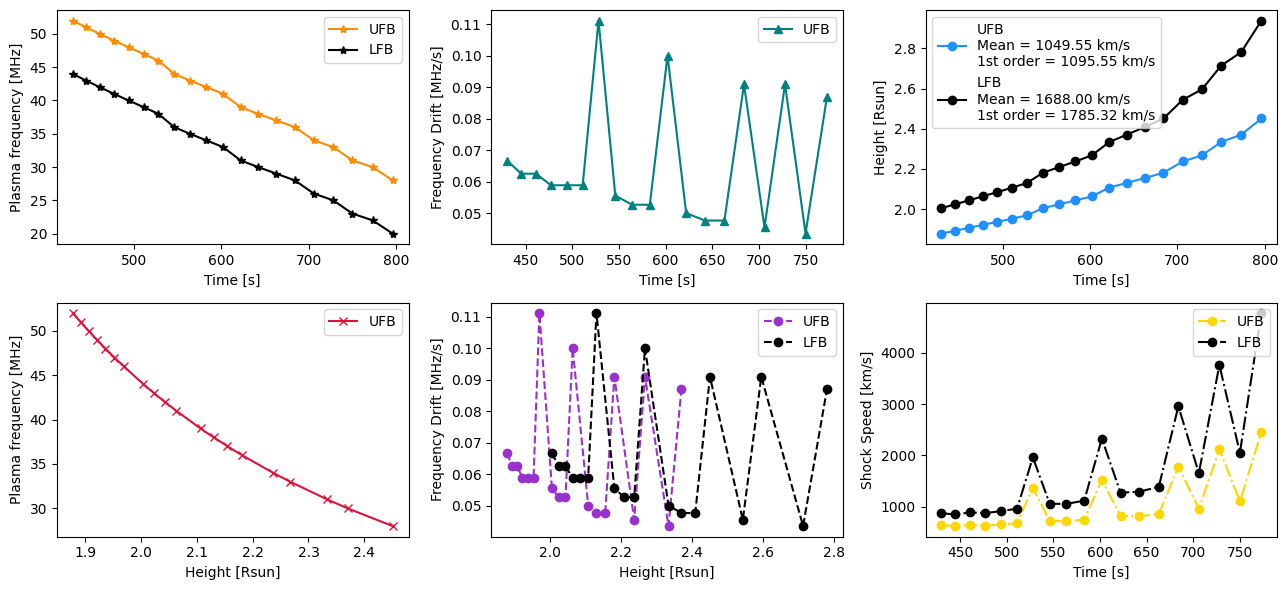

In [20]:
plt.figure(figsize=[13,6])

plt.subplot(2,3,1)
plt.plot(x_coords_U, y_coords_U, '-*', color='darkorange', label='UFB')
plt.plot(x_coords_L, y_coords_L, '-*', color='black', label='LFB')
plt.xlabel('Time [s]')
plt.ylabel('Plasma frequency [MHz]')
plt.legend(loc='upper right')

plt.subplot(2,3,2)
dfdt_U = np.abs(np.diff(y_coords_U)/np.diff(x_coords_U))
dfdt_L = np.abs(np.diff(y_coords_L)/np.diff(x_coords_L))
plt.plot(x_coords_U[:-1], dfdt_U, '-^', color='teal', label='UFB')
# plt.plot(x_coords_L[:-1], dfdt_L, '-^', color='black', label='LFB')
plt.xlabel('Time [s]')
plt.ylabel('Frequency Drift [MHz/s]')
plt.legend(loc='upper right')

plt.subplot(2,3,4)
plt.plot(rs_U, y_coords_U, '-x', color='crimson', label='UFB')
# plt.plot(rs_L, y_coords_L, '-x', color='black', label='LFB')
plt.ylabel('Plasma frequency [MHz]')
plt.xlabel('Height [Rsun]')
plt.legend(loc='upper right')

plt.subplot(2,3,5)
plt.plot(rs_U[:-1], dfdt_U, '--o', color='darkorchid', label='UFB')
plt.plot(rs_L[:-1], dfdt_L, '--o', color='black', label='LFB')
plt.ylabel('Frequency Drift [MHz/s]')
plt.xlabel('Height [Rsun]')
plt.legend(loc='upper right')

plt.subplot(2,3,6)
vr_U = np.diff(rs_U)/np.diff(x_coords_U)*700000.0
vr_L = np.diff(rs_L)/np.diff(x_coords_L)*700000.0
plt.plot(x_coords_U[:-1], vr_U, '-.o', color='gold', label='UFB')
plt.plot(x_coords_L[:-1], vr_L, '-.o', color='black', label='LFB')
plt.xlabel('Time [s]')
plt.ylabel('Shock Speed [km/s]')
plt.legend(loc='upper right')

ym_U = np.nanmean(vr_U)
ym_L = np.nanmean(vr_L)
v1_U = (rs_U[-1] - rs_U[0])/(x_coords_U[-1] - x_coords_U[0])*700000.0
v1_L = (rs_L[-1] - rs_L[0])/(x_coords_L[-1] - x_coords_L[0])*700000.0
plt.subplot(2,3,3)
plt.plot(x_coords_U, rs_U, '-o', color='dodgerblue', label=f'UFB\nMean = {ym_U:.2f} km/s\n1st order = {v1_U:.2f} km/s')
plt.plot(x_coords_L, rs_L, '-o', color='black', label=f'LFB\nMean = {ym_L:.2f} km/s\n1st order = {v1_L:.2f} km/s')
plt.xlabel('Time [s]')
plt.ylabel('Height [Rsun]')
plt.legend()

plt.tight_layout()
plt.show()